#### Imports are Necessary

In [1]:
import torch
from torch.utils.data import DataLoader

import numpy as np

from rpn.build_rpn import RPN_Model
from sam.build_sam import SAM_Model
from transformers import pipeline

from data_builder.build_dataset import PlanetscopeDataset

import json

from eval_utils import filter_boxes, calculate_iou, calculate_precision_recall

from matplotlib import pyplot as plt
from matplotlib import patches

/home/aghosh57/.conda/envs/dl4cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Usual Definition

In [2]:
with open('gen_masks_config.json', 'r') as f:
    eval_config = json.load(f)

In [3]:
print("Mask Gen Configuration")
print(json.dumps(eval_config, indent=1))

Mask Gen Configuration
{
 "DATASET_PATH": "/scratch/aghosh57/SAT-SAM(Dataset)/ps_rwanda/all_dataset/",
 "REGION": "Rwanda",
 "MODEL": "SAT-SAM",
 "NMS_THRESHOLD": 0.9,
 "PRED_CONFIDENCE_THRESHOLD": 0.6,
 "ENSEMBLE_BOX_THRESHOLD": 0.5,
 "ENSEMBLE_BOX_BETA": 0.4,
 "RPN_MODEL_PATH": "rpn/checkpoint/rpn_model_1.14_Fr_Rw.pth",
 "SAM_MODEL_PATH": "sam/checkpoint/sam_vit_l_0b3195.pth"
}


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataset = PlanetscopeDataset(eval_config['DATASET_PATH'], train=False)

In [5]:
if eval_config['MODEL'] == 'SAT-SAM':
    rpn_model = RPN_Model(eval_config['RPN_MODEL_PATH'], 2, device)
    sam_model = SAM_Model(eval_config['SAM_MODEL_PATH'], 'large', device)
elif eval_config['MODEL'] == 'SAM':
    vanilla_sam_model = pipeline("mask-generation", model="facebook/sam-vit-large", device=device)
elif eval_config['MODEL'] == 'MASKRCNN':
    maskrcnn_model = RPN_Model(eval_config['RPN_MODEL_PATH'], 2, device) #Load the Pre-Trained MaskRCNN model
    # maskrcnn_model = RPN_Model(None, 2, device)   #Load the Vanilla MaskRCNN model

In [6]:
rgb_image, rpn_image, target, ensemble = dataset[10]

In [7]:
if eval_config['MODEL'] == 'SAT-SAM':
    print('SAT-SAM')
    rpn_image = rpn_image.squeeze(0).to(device)  
    predictions = rpn_model.predict(rpn_image)
    predictions = rpn_model.postprocess(predictions, nms_threshold=eval_config['NMS_THRESHOLD'], score_threshold=eval_config['PRED_CONFIDENCE_THRESHOLD'])

    filtered_predictions = filter_boxes(predictions, ensemble, eval_config['ENSEMBLE_BOX_BETA'], eval_config['ENSEMBLE_BOX_THRESHOLD'])

    low_res_masks, iou_predictions = sam_model.predict(rgb_image, filtered_predictions)
    high_res_masks = sam_model.postprocess(low_res_masks, tuple(rgb_image.size))
    pred_masks = high_res_masks.squeeze().cpu().numpy()

elif eval_config['MODEL'] == 'SAM':
    print('SAM')
    outputs = vanilla_sam_model(rgb_image, points_per_batch=32)
    pred_masks = outputs["masks"]

elif eval_config['MODEL'] == 'MASKRCNN':
    print('MASKRCNN')
    rpn_image = rpn_image.squeeze(0).to(device)
    predictions = maskrcnn_model.predict(rpn_image)
    predictions = maskrcnn_model.postprocess(predictions, nms_threshold=eval_config['NMS_THRESHOLD'], score_threshold=eval_config['PRED_CONFIDENCE_THRESHOLD'])
    pred_masks = predictions['masks']

SAT-SAM


In [8]:
pred_masks = np.squeeze(np.array(pred_masks))

#### Plot the Predicted & Ground Truth Boxes

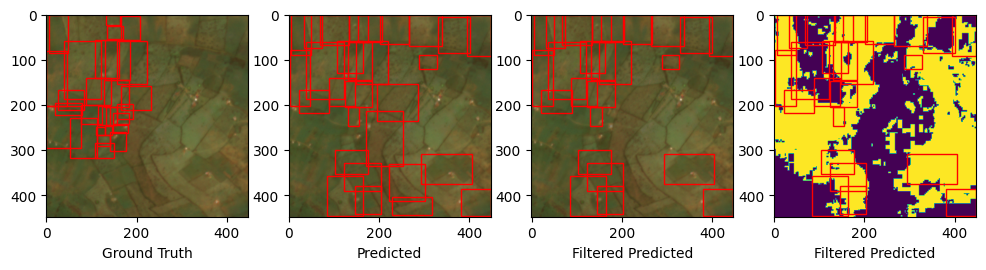

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5))

ax[0].imshow(rgb_image)
ax[0].set_xlabel('Ground Truth')

for i in range (len(target['boxes'])):
    xmin = target['boxes'][i][0]
    
    ymin = target['boxes'][i][1]
    xmax = target['boxes'][i][2]
    ymax = target['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

ax[1].imshow(rgb_image)
ax[1].set_xlabel('Predicted')

for i in range (len(predictions['boxes'])):
    xmin = predictions['boxes'][i][0]
    ymin = predictions['boxes'][i][1]
    xmax = predictions['boxes'][i][2]
    ymax = predictions['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

ax[2].imshow(rgb_image)
ax[2].set_xlabel('Filtered Predicted')

for i in range (len(filtered_predictions)):
    xmin = filtered_predictions[i][0]
    ymin = filtered_predictions[i][1]
    xmax = filtered_predictions[i][2]
    ymax = filtered_predictions[i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)


ax[3].imshow(ensemble)
ax[3].set_xlabel('Filtered Predicted')

for i in range (len(filtered_predictions)):
    xmin = filtered_predictions[i][0]
    ymin = filtered_predictions[i][1]
    xmax = filtered_predictions[i][2]
    ymax = filtered_predictions[i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[3].add_patch(rect)


plt.show()

#### Segment Anything Model

In [10]:
# Calculate the IoU
iou_score = calculate_iou(target_masks=np.array(target['masks']), predicted_masks=np.array(pred_masks))
print("Average IoU:", iou_score)

num_target_masks:  27
num_predicted_masks:  25
row_ind:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
col_ind:  [ 2  4 11  5  8  6 12  3 22 15  1 17 18  7 19 20 10 21 16 14  0  9 23 24
 13]
Average IoU: (0.4044559409124889, array([0.        , 0.        , 0.46951934, 0.        , 0.79401561,
       0.93526328, 0.        , 0.85339096, 0.78012048, 0.        ,
       0.87446708, 0.        , 0.        , 0.86312084, 0.        ,
       0.00566893, 0.95453881, 0.        , 0.86371787, 0.        ,
       0.93550673, 0.88693035, 0.        , 0.        , 0.89513823]))


#### Plot the Predicted & Ground Truth Masks

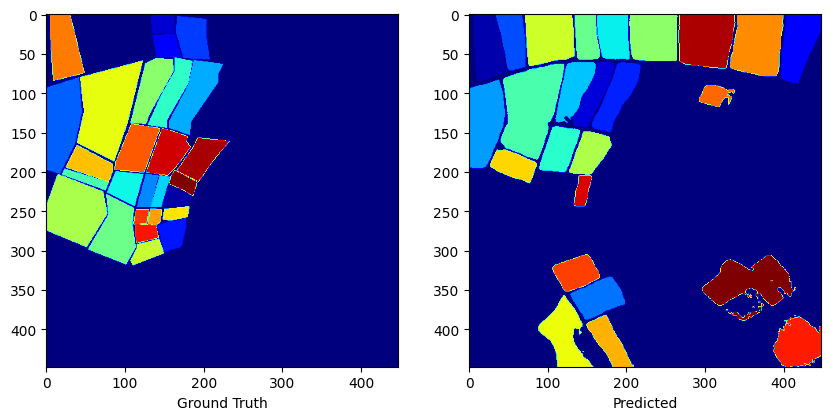

In [11]:
cumulative_high_mask = np.zeros(tuple(rgb_image.size), dtype=np.uint8)

delta_pred_mask = 255 // len(pred_masks)

for i, mask in enumerate(pred_masks):
    cumulative_high_mask[mask > 0] = (i + 1)*delta_pred_mask


cumulative_gt_mask = np.zeros(tuple(rgb_image.size), dtype=np.uint8)
delta = 100 // len(target['masks'])

for i, mask in enumerate(target['masks']):
    cumulative_gt_mask[mask > 0] = (i + 1)*delta


#Plot both masks
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(cumulative_gt_mask, cmap='jet')
ax[0].set_xlabel('Ground Truth')

ax[1].imshow(cumulative_high_mask, cmap='jet')
ax[1].set_xlabel('Predicted')

plt.show()